In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import io
import sys
import os
from pytest import approx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Importar funciones de utils
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/utils")

from utils import *

In [3]:
np.set_printoptions(precision=3, suppress=True)

# Estimación de probabilidades de incumplimiento
## Proyecto Final Optimización

Curso impartido por el profesor:
* Erick Palacios Moreno

Proyecto realizado por los estudiantes:
* Yedam Fortiz
* Nayeli Arenas
* Oscar Pérez
* Eduardo Moreno Ortiz

Este resuelve un **problema de optimización convexo** con el fin de estimar probabilidades de incumplimiento, esto es, de que un crédito sea catalogado como *default* (se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante $90$ días o más). La estructura del proyecto es la siguiente

a. Análisis exploratorio de la base de datos: **EDA/GEDA**

	a.1 Describir la estructura de los datos
	
	a.2 Describir relaciones entre variables
	
	a.3 Mostrar gráficas y resultados (tablas) relevantes
	
b. Modelo de Regresión Logística para obtención de Probabilidades de incumplimiento en el tiempo: **Modelling 1**
	
	c.1 Selección de Técnica.
	
	c.2 Obtención de Parámetros.
	
	c.3 Análisis de medidas de validación.
	
	c.4 Proyección o estimación.
    
    c.5 Implementación del modelo incluyendo componentes principales
	
c. Modelo de Regresión para uso en Credit Scoring (sobre el mapeo de WOE's): **Modelling 2**
	
	d.1 Selección de Técnica.
	
	d.2 Obtención de Parámetros.
	
	d.3 Análisis de medidas de validación.
	
d. Conclusiones

e. Software y referencias


## Introducción

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La **probabilidad de incumplimiento** se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante $90$ días o más. Generalmente se cree que la probabilidad de incumplimiento es una cantidad que puede ser tomada como una etiqueta y que esa misma etiqueta puede usarse para definir tasas de productos (*pricing*), análisis temporal o credit scoring. En este trabajo se mostrarán $2$ aplicaciones para el cálculo de probabilidad de incumplimiento.

Si el lector se llegase a preguntar *¿por qué la estimación de la probabilidad de incumplimiento es importante?* La importancia recae en el papel fundamental que tiene el proceso de calificación crediticia para el funcionamiento eficiente de los mercados de crédito y en última instancia para la estabilidad y la salud del sistema financiero y de las economías nacionales cada vez más interconectadas dentro del entramado global. 
Un proceso de calificación crediticia robusto y preciso permite a los acreedores ponderar de forma informada los riesgos asociados a un prospecto de inversión contra los potenciales rendimientos ofrecidos por éste. Estas tomas de decisiones informadas canalizan los fondos de diversos proveedores de capital con diferentes apetitos de riesgo hacia las diferentes inversiones y necesidades de consumo que mantienen a nuestras economías en constante movimiento.
Es por ende imprescindible poder contar con un modelo que permita asignar probabilidades de incumplimiento y predecir el comportamiento del deudor sobre la base de un conjunto de variables con una aportación ligada de forma plenamente identificable al desempeño de la inversión de crédito. 


### Objetivo:

Comparar modelos obtenidos por metodologías distintas (vistas en el curso *vs* metodologías implementadas en módulos de `Python`), los cuales permiten calcular la estimación de probabilidades de incumplimiento. Se tomará como referencia los modelos obtenidos 
del módulo [`statsmodel.api`](https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html).


## Problema de optimización

### Estimación de probabilidades de incumplimieto

Con el objetivo de obtener probabilidades (cumplen con los [axiomas de Kolmogorov](https://es.wikipedia.org/wiki/Axiomas_de_probabilidad#:~:text=Los%20axiomas%20de%20probabilidad%20son,formulados%20por%20Kolmog%C3%B3rov%20en%201933.)  ) se utiliza la regresión logística, que implícitamente hace mención a la función sigmoide $\sigma: \mathbb{R} \rightarrow \mathbb{R}$, que tiene la siguiente regla de correspondencia:

$$\Large \sigma(x) = \frac{1}{1+exp(-x)} $$

El objetivo del proyecto es la estimación de la probabilidad de incumplimiento (o bien que un pago sea catalogado como *default*). Para ello se identifica las siguientes $2$ clases:

* $C_1$: el préstamo es catalogado como default (no cumple con las obligaciones de pago)
* $C_0$: el préstamo es catalogado como no default (sí cumple con las obligaciones de pago)

Utilizando la función sigmoide estimaremos la probabilidad de pertenecer a la clase $C_1$ dado una serie de métricas/variables $x \in \mathbb{R}^n$:

$$\Large \mathbb{P}[C_1|x] = \sigma(a), \text{ para alguna } a \in \mathbb{R} $$


Utilizando el [Teorema de Bayes](https://es.wikipedia.org/wiki/Teorema_de_Bayes) es posible llegar al siguiente resultado:

$$\Large \mathbb{P}[C_1|x] = \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1]  } { \mathbb{P}[x|C_1] \mathbb{P}[C_1] + \mathbb{P}[x|C_0] \mathbb{P}[C_0] } = \frac{1} {1 + \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } } = \sigma(a) = \frac{1}{1+exp(-a)} $$


Por lo tanto,

$$\Large a(x) = log( \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } ) $$


El modelo de regresión logística (para $2$ clases) parte de un modelo lineal en sus parámetros $\beta \in \mathbb{R}^n$ (donde $n$ indica la cantidad de variables/métricas a medir). Se añade un parámetro adicional $\beta_0$, por lo que el modelo tiene la siguiente forma:

$$\Large \beta^Tx + \beta_0= a(x|\beta, \beta_0) = log( \frac{ \mathbb{P}[C_1|x]  }{ \mathbb{P}[C_0|x]  } )  $$

Si $y$ es tomada como variable de respuesta, entonces se obtiene que está en función de $x \in \mathbb{R}^{n+1}$ dado el vector $\beta_0, \beta$. La regla de correspondencia es la siguiente:

$$\Large \mathbb{P}[C_1|x] = y(x | \beta_0, \beta) = \frac{ 1 } {1+exp(-(\beta_0 + \beta^Tx)) }  $$

En donde, la variable de optimización es $(\beta_0, \beta) \in \mathbb{R}^{n+1}$

Para el ajuste de los parámetros se utiliza la [metodología estudiada en el curso](https://itam-ds.github.io/analisis-numerico-computo-cientifico/III.optimizacion_convexa/3.3/Ejemplos_problemas_UCO_e_intro_CIEO_y_PI.html#como-se-ajustan-los-parametros-del-modelo-por-regresion-logistica-de-dos-clases), que se basa en maximizar la [función de verosimilitud](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_verosimilitud#:~:text=En%20estad%C3%ADstica%2C%20la%20funci%C3%B3n%20de,de%20un%20conjunto%20de%20observaciones.), que es equivalente a minimizar la función log-verosimilitud, el cual es equivalente a minimizar la [devianza](https://en.wikipedia.org/wiki/Deviance_(statistics)):

$$ \Large \text{min}_{\beta_0,\beta_1 \in \mathbb{R}^{n+1}} D(\beta_0, \beta|x) = -2 l(\beta_0, \beta|x) = \sum_{i=1}^m \text{log}( 1 + exp( (\beta_0,\beta )^Tx_i ) ) -\hat{y}_i(\beta_0,\beta )^Tx_i $$

En las notas del curso, se demuestra que la Hessiana de la devianza es una matriz simétrica semidefinida positiva y por tanto la función planteada previamente es una función convexa. Por lo que, en este proyecto se resolverá un **problema optimización (minimización) convexo.**

Este análisis minusioso de la función sigmoide y desarrollo matemático fue tomado del libro de [Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/README.html) cuyo autor es el profesor **Erick Palacios Moreno**.

### Estimación de Componentes Principales
El problema a resolver para poder calcular las componentes principales, es el siguiente:

$$ \Large \text{max}_{u_i \in \mathbb{R}^p} \quad u_i^T S u_i \\
    \quad \text{ s.a. } \quad u_i^Tu_i = 1 \\
    \quad \text{ s.a. } \quad u_iTu_j = 0 \forall 1 \leq j < i$$

En donde,
* $ S = \frac{1}{n} \sum_{i=1}^n x_ix_i^T = X^TX/n $
* $S$ recibe el nombre de matriz de varianzas y convarianzas
* $x_i \in \mathbb{R}^p$ es un vector columna de $p$ features. 



## Herramientas adicionales del curso de Optimización
### Cálculo de componentes principales mediante el uso del método de la potencia y deflación


Para reducir la dimensionalidad se utilizará la metodología de Análisis de Componentes Principales (*PCA* por sus siglas en inglés). En el cual se basa en la obtención de los eigenvectores y eigenvalores de la matriz de covarianza de las variables a las cuales se busca reducir la dimensión. Para este proyecto, se utilizará únicamente la primera y segunda componente principal, las cuales serán calculadas mediante el uso del método de la potencia y deflación respectivamente. Tal y como se estudió en el curso, el método de la potencia ayuda a encontrar el eigenvector asociado al eigenvalor de máximo módulo, para encontar el segundo eigenvalor de máximo módulo se utiliza el siguiente resultado matemático, que hace referencia al método de deflación:
 * Teorema: sea $A$ una matriz de $n\text{x}n$ con eigenvalores $\lambda_1, \lambda_2, ... , \lambda_n$ con respectivos eigenvectores $v_1, v_2, ..., v_n$ (todos de norma unitaria). Entonces la matriz, 
 $$ B = A - \lambda_1 v_1v_T $$
 tiene eigenvalores $0, \lambda_2, \lambda_3, ..., \lambda_n$ y eigenvectores respectivos $v_1, v_2, ... , v_n$. 


## Datos:

Para cumplir con el objetivo y los puntos de este proyecto, se utilizará la información de 60 trimestres de 5,000 créditos hipotecarios de Estados Unidos tomada de portafolios bursatilizados (RMBSs) a partir del año 2000 hasta 2015. El proveedor de la base es la instutición estadounidense [**International Financial Reasearch**](http://www.internationalfinancialresearch.org/). Cabe mencionar, que se  tiene acceso a ella por la adquisición del libro *Deep Credit Risk de Daniel Rosch y Harald Scheule*, el cual es la principal fuente de este proyecto.
Dentro de la base de datos cada observación (*renglón*) corresponde a un préstamo otorgado por la institución hipotecaria.

A continuación, se enunciará y describirán las variables que posee la base de datos:

1. *id*.- clave única por respondiente, dado que los préstamos se otorgan por distintos periodos de tiempo, el valor de esta variable se repite por varios préstamos (*renglones*).

1. *time*.- periodo observado identificado como trimestres deade el año $2000$ hasta $2015$, de tal manera que, $1$ corresponde al primer trimestre del año $2000$, $2$ al segundo trimestre del año $2000$, ...

1. *orig_time*.- trimestre en el que se otorgó el crédito. Si se otorgó previo al 2000, el número es negativo.

1. *first_time*.- trimestre en el que aparece el crédito se da de alta a la base de datos.

1. *mat_time*.- plazo del crédito (las unidades son trimestres).

1. *res_time*.- trimestre en el que se recuperó la vivienda.

1. *balance_time*.- saldo del respondiente al trimestre de observación. La unidad de medición son dólares americanos.

1. *LTV_time*.- Loan to Value a la originación (endeudamiento de un activo en relación con su valor real y actual). Para obtener una descripción más detallada se recomienda visitar el siguiente [link](https://www.ilpabogados.com/que-es-el-loan-to-value-ltv-y-por-que-es-relevante/). La unidad de medición son dólares americanos.

1. *interest_rate_time*.- tasa de interés en el trimestre correspondiente.

1. *rate_time*.- tasa libre de riesgo en el trimestre correspondiente.

1. *hpi_time*.- índice de precios de casas en el trimestre correspondiente.

1. *gdp_time*.- tasa de crecimiento del PIB en el trimestre correspondiente.

1. *uer_time*.- tasa de desempleo del trimestre correspondiente.

1. *REtype_CO_orig_time*.- identificador de condominio (condominio 1, en otro caso 0)

1. *REtype_PU_orig_time*.- identificador de desarrollo urbano (desarrollo urbano 1, en otro caso 0)

1. *REtype_SF_orig_time*.- identificador de vivienda familia unitaria (vivienda para una sola familia 1, en otro caso 0)

1. *investor_orig_time*.- identificador de  desarrollador, el cual es similar a una empresa dedicada a la construcción de hogares y viviendas (la casa fue construía por un desarrollador  1, en otro caso 0)

1. *balance_orig_time*.- monto del préstamo otorgado, las unidades de medición son dólares americanos.

1. *FICO_orig_time*.- [FICO score](https://www.ficoscore.com/ficoscore/pdf/Understanding-FICO-Scores-SPANISH.pdf) en el momento de originar el préstamo.

1. *LTV_orig_time*.- Loan to Value al momento de la originación del préstamo (las unidades de medición son dólares americanos).

1. *Interest_Rate_orig_time*.- tasa de interés del préstamo otorgado en el momento de la originación.

1. *state_orig_time*.- Estado de la unión americana donde se encuentra la vivienda (52 estados en total).

1. *hpi_orig_time*.- índice de precios de casa al momento de la originación.

1. *default_time*.- indicadora de incumplimiento de pago (no se cumplió con la obligación de pagar el préstamo dado el trimestre correspondiente 1, en otro caso 0).

1. *payoff_time*.- indicadora de liquidación (liquidación 1, en otro caso 0).

1. *status_time*.- variable categórica con 3 niveles: 1 préstamo se declaró en default (no se cumplió con la obligación de pagarlo), 2 (se cumplió con la obligación de pagar), 0 en otro caso.

1. *lgd_time*.- [Loss given default](https://accionistaseinversores.bbva.com/microsites/informes2009/es/Gestiondelriesgo/Severidadlgd.html) o severidad al momento del default, las unidades de medición son dólares americanos.

1. *recovery_res*.- suma de los flujos recibidos durante el periodo de resolución, las unidades de medición son dólares americanos o bien, es el monto de  dinero que se recupera por adjudicar o quitar un inmueble.


## Pasos a seguir para resolver los problemas de optimización y de estimación de componentes principales

El *pseudo-algoritmo* a seguir para la aproximación a las componentes principales y de las estimaciones a la probabilidad de incumplimiento es el siguiente:

1. Obtener el modelo de regresión logística tomando en cuenta las variables denominadas variables explicativas: se utilizará la función `fsolve` y `cvxpy` que nos ayudan a minimizar una función convexa.
1. Comparar el modelo obtenido en el paso anterior con el modelo obtenido con la función `smf` de la librería `glm`.
1. Cálculo de las primera y segunda componente principal: se utilizará el método de la potencia y de deflación.
1. Comparar dichas componentes principales con las obtenidas con la función `pca` que realiza dicho cómputo.
1. Incorporar las componentes principales al conjunto de variables explicativas y obtener otro modelo de regresión logística.
1. Comparar el modelo obtenido en el paso anterior con el modelo obtenido con la función `smf` de la librería `glm`.
1. Cálculo del modelo para las estimaciones de probabilidad de incumplimiento utilizando la metodología de Credit-Scoring: se utilizará la función `fsolve` y `cvxpy` que nos ayudan a minimizar una función convexa.
1. Comparar el modelo obtenido en el paso anterior con el modelo obtenido con la función `smf` de la librería `glm`.


### Integrantes y asignación de tareas del equipo

|User | Nombre Completo| Tarea |
|:---:|:---:|:---:|
|@oaperez3|Oscar Perez|Project manager, levantamiento de instancia en AWS, implementación de metodología, responder preguntas
|@Eduardo-Moreno|Eduardo Moreno|Investigación de variables, implementación metodología, responder preguntas
|@yefovar|Yedam Fortiz|Testing, estudio de parte matemática, expositor
|@arenitss|Nayeli Arenas|Redacción, revisón de resultados, expositor




# a. Análisis Exploratorio de Datos (*EDA*)

### Lectura y preparación de datos

In [4]:
data = pd.read_csv('../data_t_final.csv')

Las dimensiones (cantidad de variables y observaciones) son

In [5]:
print('Cantidad de observaciones (renglones): ', data.shape[0])
print('Cantidad de variables: ', data.shape[1])

Cantidad de observaciones (renglones):  62178
Cantidad de variables:  28


Las variables con las que cuenta el `dataset` son las siguientes

In [6]:
for column in data.columns:
    print(column)

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


### Datos faltantes

La proporción de valores faltantes por cada variables se muestra a continuación:

In [7]:
data.isna().mean()

id                         0.000000
time                       0.000000
orig_time                  0.000000
first_time                 0.000000
mat_time                   0.000000
res_time                   0.981344
balance_time               0.000000
LTV_time                   0.000402
interest_rate_time         0.000000
rate_time                  0.000000
hpi_time                   0.000000
gdp_time                   0.000000
uer_time                   0.000000
REtype_CO_orig_time        0.000000
REtype_PU_orig_time        0.000000
REtype_SF_orig_time        0.000000
investor_orig_time         0.000000
balance_orig_time          0.000000
FICO_orig_time             0.000000
LTV_orig_time              0.000000
Interest_Rate_orig_time    0.000000
state_orig_time            0.005629
hpi_orig_time              0.000000
default_time               0.000000
payoff_time                0.000000
status_time                0.000000
lgd_time                   0.975474
recovery_res               0

Las variables con mayor cantidad de valores faltantes son:
1. `res_time`.- periodo en el que se recuperó la vivienda.
1. `lgd_time`.- severidad al momento del default (declaración de incumplimiento de pago).
1. `recovery_res`.- suma de los flujos recibidos durante el periodo de resolución
1. `LTV_time`.- *Loan to Value* en el momento de la originación
1. `state_orig_time`.- Estado de la unión americana en donde se originó el préstamo

Se desconoce la razón real por la cual hay una cantidad muy alta de valores faltantes para dichas variables, sin embargo, se cree lo siguiente para las primeras $3$ variables:
 
* No se le dio el seguimiento requerido para capturar la fecha en la cual se recuperó la vivienda.
* No fue posible estimar la severidad o los montos por adjudicar bienes debido a falta de información (bienes mal valuados).
* Víctima de cyberataque.
* Fallo en los servidores que guardan la información.


Para las primeras $3$ variables la cantidad de valores faltantes es demasiado alta, de manera que si se omitieran dichos valores faltantes, entonces la base de datos contaría aproximadamente con el $2\%$ de las observaciones originales, por lo que se omitirán dichas variables y posteriormente se omitirán los valores faltantes que corresponden aproximadamente al $0.5629\%$. Cabe recalcar que se omiten debido a que si no se hiciese de tal manera se perdería la mayoría de la información que se encuentra en la base de datos y no se podría seguir con el análisis.

In [8]:
selected_data = data.drop(['res_time', 'lgd_time', 'recovery_res'], axis=1).dropna()
selected_data.isna().mean()

id                         0.0
time                       0.0
orig_time                  0.0
first_time                 0.0
mat_time                   0.0
balance_time               0.0
LTV_time                   0.0
interest_rate_time         0.0
rate_time                  0.0
hpi_time                   0.0
gdp_time                   0.0
uer_time                   0.0
REtype_CO_orig_time        0.0
REtype_PU_orig_time        0.0
REtype_SF_orig_time        0.0
investor_orig_time         0.0
balance_orig_time          0.0
FICO_orig_time             0.0
LTV_orig_time              0.0
Interest_Rate_orig_time    0.0
state_orig_time            0.0
hpi_orig_time              0.0
default_time               0.0
payoff_time                0.0
status_time                0.0
dtype: float64

In [9]:
print('Cantidad de observaciones (renglones): ', selected_data.shape[0])
print('Cantidad de variables: ', selected_data.shape[1])

Cantidad de observaciones (renglones):  61803
Cantidad de variables:  25


In [10]:
print('Porcentaje de observaciones (renglones) pérdidas: ', 100- selected_data.shape[0]/data.shape[0]*100, '%')
print('Porcentaje de variables pérdidas: ',100- selected_data.shape[1]/data.shape[1]*100, '%')

Porcentaje de observaciones (renglones) pérdidas:  0.6031072083373488 %
Porcentaje de variables pérdidas:  10.714285714285708 %


Se pierde menos del $1\%$ de información al omitir los obervaciones en donde se tenía valores faltantes ya fuese en la variable `state_orig_time` y/o `LTV_time`, el cual no es un porcentaje alto y la pérdida de información es mínima.

### Exploración de datos - estructura de variables

El `dataset` con el que se trabajará en el presente documento tiene la siguiente estructura

In [11]:
selected_data.head(5)

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,4,25,-2,25,119,61031.10,33.911009,10.500,5.9,226.29,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
1,4,26,-2,25,119,60882.42,34.007232,10.500,5.9,225.10,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
2,4,27,-2,25,119,60729.80,34.335349,10.500,5.9,222.39,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
3,4,28,-2,25,119,60576.14,34.672545,10.875,5.9,219.67,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
4,4,29,-2,25,119,60424.39,34.951639,10.875,5.9,217.37,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0


Cabe recordar al lector, que cada observación (renglón) del `dataset` representa préstamos realizados a una determinada fecha, la cual indica el número de trimestre, iniciando desde el primer semestre del año $2000$ y finalizando en el último trimestre del año $2015$.

In [12]:
print('Cantidad de acreditados únicos: ', len(selected_data.id.unique()))
print('Cantidad de trimestres: ', len(selected_data.time.unique()))

Cantidad de acreditados únicos:  4979
Cantidad de trimestres:  60


Se le realizaron préstamos a $4,979$ personas distintas a lo largo de $60$ trimestres que corresponden a los $15$ años del periodo de estudio.

In [13]:
print('Cantidad de Estados: ', len(selected_data.state_orig_time.unique()))

Cantidad de Estados:  52


Se tiene información de los 52 estados que componene a Estados Unidos de América. La cantidad de observaciones por estado es la siguiente:

In [14]:
pd.crosstab(index=selected_data["state_orig_time"], columns="count").sort_values('count', ascending=False)

col_0,count
state_orig_time,
CA,12582
FL,6175
TX,3893
NY,2947
GA,2649
IL,2350
AZ,2171
VA,2070
OH,1726


Nótese que los estados con mayor cantidad de préstamos son:
1. California (CA)
1. Florida (FL)
1. Texas (TX)

Que corresponden a los estados con mayor población según [reportes](https://datosmacro.expansion.com/demografia/poblacion/usa-estados) al año 2019, por lo que, podría pensarse (faltaría comprobarlo) que los préstamos realizados siguen un comportamiento a distribución población, es decir, que depende de la cantidad de personas del estado la cantidad de préstamos realizados.

Al momento que se se genera un préstamo se cuenta con las siguienes variables:
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`
* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `state_orig_time`
* `hpi_orig_time`

Por lo que se enfocarán los esfuerzos, en primer lugar, a analizar dichas variables y en la variable `default_time`, ya que es la variable que nos indica si un préstamo fue catalogado como default (no cumplimiento con las obligaciones de pago), en el trimestre correspondiente o no.

In [15]:
selected_data[['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time',
             'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'state_orig_time',
             'hpi_orig_time','default_time']].describe()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time
count,61803.000000,61803.000000,61803.000000,61803.000000,6.180300e+04,61803.000000,61803.000000,61803.000000,61803.000000,61803.000000
mean,0.061033,0.128198,0.607818,0.146271,2.551075e+05,673.489879,78.692758,5.595503,198.760887,0.024578
std,0.239392,0.334312,0.488241,0.353381,2.118775e+05,71.904099,10.226046,2.971053,33.428980,0.154837
min,0.000000,0.000000,0.000000,0.000000,6.246000e+03,429.000000,50.100000,0.000000,75.730000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.076230e+05,628.000000,75.000000,4.875000,186.910000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.880000e+05,675.000000,80.000000,6.250000,216.770000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,3.500000e+05,730.000000,80.000000,7.375000,223.750000,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.107000e+06,819.000000,119.800000,15.000000,226.290000,1.000000


Como ya se había mencionado previamente las variables `REtype_CO_orig_time`, `REtype_PU_orig_time`, `REtype_SF_orig_time`, `investor_orig_time` y `default_time` son binarias (sólo toman $2$) tal y como se había mencioando previamente. Además la proporción de $1$ en la variable de `default_time` es la menor. Que es un suceso esperado, esto quiere decir, que no todos los préstamos caen en default, es decir, no cumplen con sus obligaciones de pago. La variable `REtype_CO_orig_time` nos indica que la mayoría de los préstamos realizados corresponden a viviendas que **no** son condominios.

Un hecho interesante, es que la mayoría de los préstamos, son dados a viviendas que no tienen desarrollo urbano. Esto nos lo indica la media de `REtype_PU_orig_time`.

Para las variables numéricas se realizan los siguientes comentarios:
* `balance_orig_time`.- el monto del crédito mínimo fue aproximadamente de $\$255,107.5$ dólares, mientras que el más alto de casi $\$3,000,000$ dólares, lo cual nos indica que es una variable con alta dispersión.
* `FICO_orig_time`.- la desviación estándar es aproximadamente de $\$71$ dólares, dada la escala (mínimo y máximo), deducimos que no presenta una alta dispersión.
* `LTV_orig_time`.- análogo a la variable anterior.
* `Interest_Rate_orig_time`.- es interesante que la tasa de interés mínima fue de $0\%$, lo cual, indica que para dicho préstamo, no se generaron intereses. Sin embargo, la tasa máxima de interés fue de $15\%$.
* `hpi_orig_time`.- dada la escala de las variables y la desviación estándar, concluímos que no posee una alta dispersión.

El siguiente paso del análisis exploratorio es observar la dispersión de los datos para ello utilizaremos diagramas de cajas y brazos únicamente de las variables siguientes:

* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `hpi_orig_time`

Debido a que son las variables que se obtienen al momento de generar el préstamo, a continuación se analizarán los diagramas de caja para dichas variables en escala logarítmica, ya que hemos analizado que presentan una alta dispersión.

In [16]:
variables = ['balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']

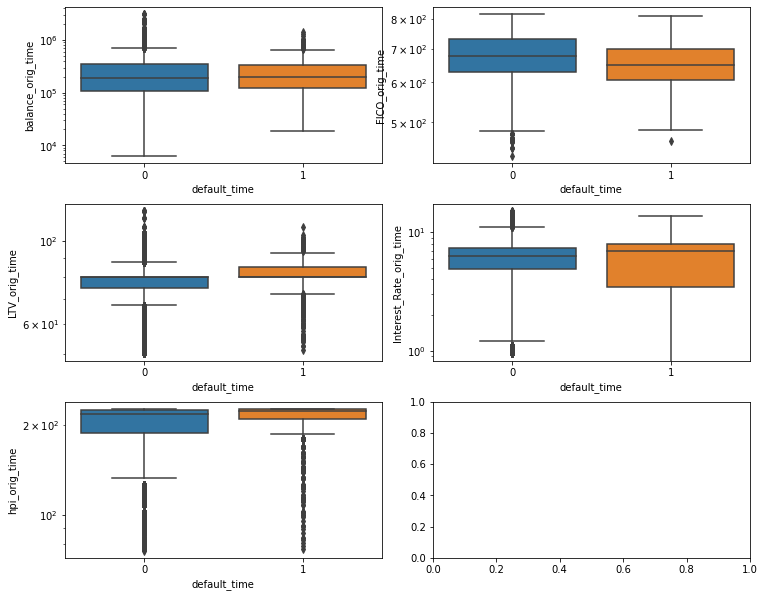

In [17]:
n = len(variables)
fig, ax = plt.subplots(3,2, figsize=(10.5,8.5))
#fig.set_size_inches(5.5, 20.5)
loc_i = [0,0,1,1,2]
loc_j = [0,1,0,1,0]
fig.tight_layout(pad=2)

for i in range(n):
    g = sns.boxplot(x='default_time', y = variables[i], data = selected_data, ax = ax[loc_i[i]][loc_j[i]])
    g.set(yscale = 'log')

En primera instancia, es difícil analizar la dispersión de las variables debido a la cantidad de valores atípicos, mas es posible notar lo siguiente.
La variable `balance_orig_time`, presenta una estructura muy similar para ambas categorías de la varaible `default_time`, sin embargo, la cantidad de valores atípicos para la clase $0$ son mayores.

Notemos que para las variables `Interest_Rate_orig_time` y `LTV_orig_time` la media es superior para el grupo identificado como *default* (o clase $1$) que para el *no default*. Mientras que para la variable `FICO_orig_time` ocurre lo contrario. Además, la dispersión para el grupo *default* de la variable `Interest_Rate_orig_time` es mayor y para la variable `hpi_orig_time` es mayor para el grupo *no default*.

La cantidad de valores atípicos por variable es la siguiente:

In [18]:
selected_data_at = selected_data[variables]
Q1 = selected_data_at.quantile(0.25)
Q3 = selected_data_at.quantile(0.75)
IQR = Q3 - Q1

La cantidad de valores atípicos por variable se calculará a continuación.

In [19]:
print(((selected_data_at < (Q1 - 1.5 * IQR)) | (selected_data_at > (Q3 + 1.5 * IQR))).sum())
print('\nCantidad relativa de outliers: ')
print((((selected_data_at < (Q1 - 1.5 * IQR)) | (selected_data_at > (Q3 + 1.5 * IQR))).sum())/selected_data_at.shape[0])

balance_orig_time           1956
FICO_orig_time                36
LTV_orig_time              19358
Interest_Rate_orig_time    10660
hpi_orig_time               3392
dtype: int64

Cantidad relativa de outliers: 
balance_orig_time          0.031649
FICO_orig_time             0.000582
LTV_orig_time              0.313221
Interest_Rate_orig_time    0.172484
hpi_orig_time              0.054884
dtype: float64


Notemos que las variables `LTV_orig_time` y `Interest_Rate_orig_time` son las que presentan una mayor cantidad de valores atípicos, nuestra hipótesis es que este fenómeno se debe a la [crisis inmobiliaria del $2008$](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008) que ocasionó enormes cambios en el sistema económico y financiero a nivel mundial. A continuación se analizarán las mismas variables, pero sin valores atípicos.

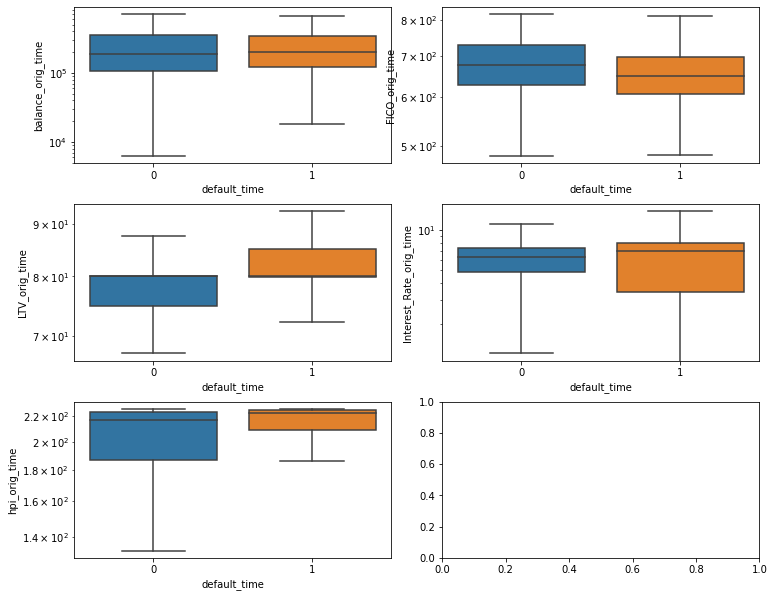

In [20]:
n = len(variables)
fig, ax = plt.subplots(3,2, figsize=(10.5,8.5))
loc_i = [0,0,1,1,2]
loc_j = [0,1,0,1,0]
fig.tight_layout(pad=2)

for i in range(n):
    g = sns.boxplot(x='default_time', y = variables[i], data = selected_data, showfliers = False, 
                    ax = ax[loc_i[i]][loc_j[i]])
    g.set(yscale = 'log')

Lo cual nos da un gran apoyo visual para identificar que la variable `LTV_orig_time`, es la que presenta una mayor diferencia entre los créditos incumplidos (`default_time`=1) y los cumplidos (`default_time`=0)

Para las variables dicotómicas a continuación se calculará la desviación estándar y la media, dichas variables son las siguientes:
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`

In [21]:
var_dic = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 
           'default_time']

In [22]:
selected_data[var_dic].groupby(['default_time']).mean()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time
default_time,,,,
0,0.061277,0.128094,0.607176,0.14639
1,0.051350,0.132324,0.633311,0.14154


Notemos que la proporción para las variables dicotómicas es muy parecida a excepción de la variable `REtype_SF_orig_time`, que indica la proporción de préstamos realizados a individuos con vivienda unitaria. Nótese que esta proporción es mayor para la categoría *default* (aquellos préstamos que no cumplieron con sus obligaciones de pago). Ante este fenónemo tenemos la siguiente hipótesis:
* Dado que es una vivienda unitaria, el ingreso se limita a lo recibido por una persona que en el caso donde no es unitaria y existen más aportadores de ingresos a la economía del hogar, por lo que, para el primer caso cumplir con las obligaciones de pago puede llegar a ser más difícil que para el segundo.

In [23]:
selected_data[var_dic].groupby(['default_time']).std()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time
default_time,,,,
0,0.239839,0.334197,0.488382,0.353500
1,0.220782,0.338954,0.482059,0.348693


La desviación estándar es muy similar para todas las variables dicotómicas.

Por último, se analizará la estructura de correlación entre las variables numéricas generadas al momento de realizar un préstamo. **¿Por qué se analiza la correlación?** Debido a que se utilizará un modelo lineal, el cual presenta problemas de inestibilidad numérica cuando se tienen variables con correlación lineal alta. 

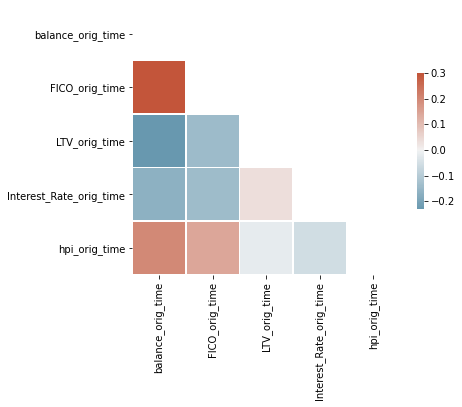

In [24]:
corr_plot(selected_data, variables)

El previo gráfico muestra las correlaciones lineales por variables, del cual se deduce que para las variables numéricas esta correlación es baja, por lo que el uso del modelo de regresión logística no debería presentar problemas de inestabilidad numérica para dichas variables.

### EDA - Hallazgos importantes 
* Las variables que se obtienen la momento de generar un préstamo no presentan una estructura alta de correlación, lo cual ayuda al modelo de regresión logística en el problema de multicolinealidad.
* Dichas variables por sí solas, no ayudan a distinguir los préstamos que caerán en default o no, por lo que será necesario de técnicas más robustas para tratar dichas variables (transformaciones **no lineales**).
* La distribución de préstamos realizados en Estados Unidos de América pareciése que sigue un comportamiento poblacional.
* La proporción de viviendas unitarias presentan una mayor tasa de *default* (no cumplir con obligación de pago) que las viviendas no unitarias.

# b. Modelo de Regresión Logística para obtención de Probabilidades de incumplimiento en el tiempo
# Modelling 1

El *dataset* utilizado para la modelación recibió el tratamiento de eliminar NA's.

El objetivo de la estimación es predecir si un préstamo es catalogado como *default* (el responsable de realizar el pago no cumple con las obligaciones de saldar la deuda adquiridas al obtener el préstamo) mediante la estimación de probabilidades de incumplimiento que se obtienen mediante la optimización del problema convexo previamente mencionado. La variable independiente es `default_time`.

### Obtención del modelo

In [25]:
modeling1 = data.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

Uso de la función `estim_prob` que resuelve el problema de optimización.

In [26]:
fitted_values , model = estim_prob(modeling1,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13296.454946928172


Los coeficientes de la regresión logística son los siguientes:

In [27]:
model

array([-4.794,  0.   ,  0.186,  0.118, -0.013, -0.093, -0.041, -0.045,
       -0.008,  0.19 , -0.   , -0.004,  0.022, -0.022,  0.015, -0.003])

Como comparación al modelo obtenido se utilizará el modelo modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html).

In [28]:
model_lr = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + uer_time + REtype_CO_orig_time + gdp_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time ', family = sm.families.Binomial(), data = modeling1).fit()

In [29]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62137
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6648.2
Date:                Wed, 09 Dec 2020   Deviance:                       13296.
Time:                        09:33:21   Pearson chi2:                 5.76e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

A continuación se muestran las principales métricas del modelo. Podemos notar que las siguientes variables no son significativas : `REtype_CO_orig_time` y `REtype_SF_orig_time`; es decir, su aportación a la varianza explicada de la variable dependiente default_time es casi nula en presencia de las demás variables del modelo.

Verificaremos que los coeficientes entre ambas estimaciones son similares, calcularemos la aproximación de ambos vectores con approx de pytest.

In [30]:
print(model == approx(np.array(model_lr.params), abs=1e-1, rel=1e-1))

True


In [31]:
PD_logit_model = pd.DataFrame(fitted_values, columns=['PD_logit_model'])

In [32]:
data2 = pd.merge(modeling1[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

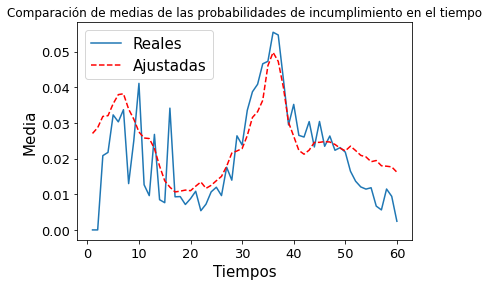

In [33]:
grafica_medias(data2.PD_logit_model, data2.default_time, data2.time)

La grafica muestra un compartamiento similar del ajuste contra los valores reales.
Podemos notar que tanto en periodos de incumplimiento bajo y alto la tendencia sigue el mismo patrón. Nótese que alrededor del periodo treinta creció debido a la crisis inmobiliaria del 2008-2009.

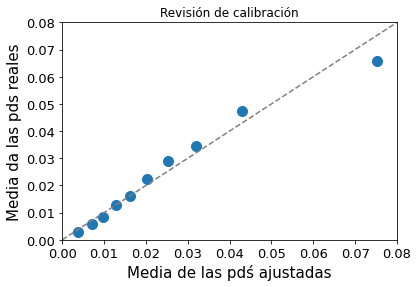

In [34]:
grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time)

El ajuste de las medias reales contra las medias ajustadas no presenta desviaciones considerables, incluso para valores dispersos esta comportamiento se mantiene.

### Componentes principales

El analisis de componentes principales se hará para ejemplificar la reducción de dimensionalidad de la variable `states_orig_time`, que es una variable categórica con $52$ niveles, en donde cada nivel corresponde a un Estado de USA. Dado que es una variable categórica, debe ser transformada mediante el uso de la metodología *One Hot Encoding* que automáticamente creará $52$ variables adicionales (una para cada Estado). Por lo que se usará PCA para reducir la dimensión de $52$ a una más pequeña.

Cálculo de tasas y estandarización

In [35]:
defaultrates_states1 = modeling1.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)
cov = np.cov(defaultrates_states.T)

Obtener componentes principales usando método de potencia y deflación que nos ayudan a encontrar los eigenvectores asociados a los 2 eigenvalores de máximo módulo, respectivamente.

In [36]:
eigenvalor,eigenvector = potencia(cov,MAX=1000)
eigenvalor2,eigenvector2 = deflacion(cov,MAX=1000)

In [37]:
cp1 = eigenvector@defaultrates_states.T
cp2 = eigenvector2@defaultrates_states.T

### Resolucion del problema utilizando funciones predeterminadas

In [38]:
pca=PCA()
pca.fit(defaultrates_states)
z = pca.transform(defaultrates_states)

### Comparación de resultados entre los diferentes métodos

Verificaremos que las componentes principales entre ambas estimaciones sean similares, calcularemos la aproximación con approx de pytest.

In [39]:
print(cp1 == approx(z[:,0], abs=1e-1, rel=1e-1))
print(-cp2 == approx(z[:,1], abs=1e-1, rel=1e-1))

True
True


### Introduccion de las componentes principales a la base de datos

Una vez obtenido las dos compementos principales de mayor importancia, la importancia de la componente principal depende del módulo del eigenvalor respectivo. Procedemos a incoporarlas a las variables predictivas para posteriormente incoporar una regresión logística.

In [40]:
cpa = pd.DataFrame(pd.DataFrame([cp1,-cp2,defaultrates_states1['time']]).T)
cpa = cpa.rename(columns={0:'cpa1',1:'cpa2',2:'time' })
data_cpa = modeling1.merge(cpa,how='left')

### Resolucion del problema utilizando herramientas avanzadas de optimizacion

Uso de la función `estim_prob` que resuelve el problema de optimización.

In [41]:
fitted_values_cpa , model_cpa = estim_prob(data_cpa,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time',
                                               'cpa1','cpa2'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13243.32927189312


Los coeficientes de la regresión logística son los siguientes:

In [42]:
model_cpa

array([-5.546,  0.   ,  0.176,  0.15 , -0.01 ,  0.018,  0.01 , -0.045,
       -0.004,  0.185, -0.   , -0.004,  0.022, -0.022,  0.012, -0.003,
        0.125,  0.009])

### Resolucion del problema utilizando funciones predeterminadas

In [43]:
model_lr_cpa = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time + cpa1 + cpa2', family = sm.families.Binomial(), data = data_cpa).fit()

### Comparacion de resultados entre los diferentes metodos

Verificaremos que los coeficientes entre ambos son similares, calcularemos la aproximación de ambos vectores con approx de pytest.

In [44]:
print(model_cpa == approx(np.array(model_lr_cpa.params), abs=1e-1, rel=1e-1))

True


In [45]:
print(model_lr_cpa.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62135
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6621.7
Date:                Wed, 09 Dec 2020   Deviance:                       13243.
Time:                        09:34:44   Pearson chi2:                 5.73e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Podemos notar que al incoporar la información de los `state_orig_time` las variables que no son significativas son `gdp_time`, `uer_time`, `REtype_CO_orig_time`, `REtype_SF_orig_time` y `cpa2`.

In [46]:
PD_logit_model_cpa = pd.DataFrame(fitted_values_cpa, columns=['PD_logit_model'])

In [47]:
data2_cpa = pd.merge(modeling1[['default_time','time']],PD_logit_model_cpa, right_index=True, left_index=True)

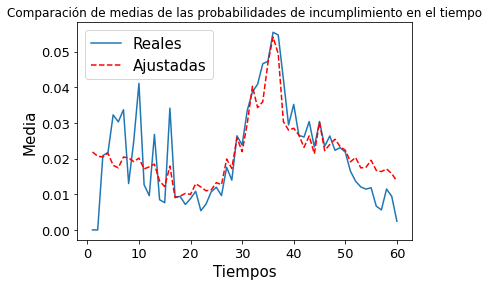

In [48]:
grafica_medias(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)

La grafica muestra una subestimacion en la probabilidad de incumplimiento para los primeros periodos, mientras que a partir del tiempo 20 la estimacion muestra un comportamiento muy parecido a los valores reales.

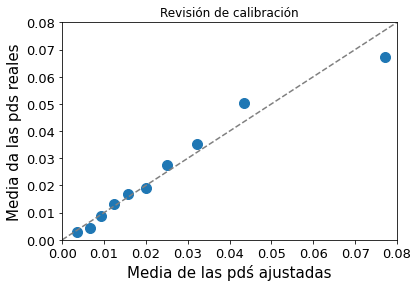

In [49]:
grafica_ajuste(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)

El ajuste de las medias reales contra las medias ajustadas no presenta desviaciones considerables, incluso para valores dispersos esta comportamiento se mantiene.

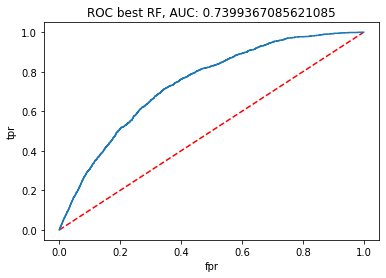

In [50]:
fpr, tpr, thresholds = roc_curve(modeling1['default_time'], fitted_values_cpa, pos_label=1)
    
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(modeling1['default_time'], fitted_values_cpa)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()    

Una manera de evaluar la discriminación dada por el modelo se realiza mediante la [Curva Roc](http://www.navan.name/roc/).
Una curva alejada a la línea punteada representa un modelo de discriminación adecuado. 

### Resultados

* El ajuste mediante regresión logística junto con componentes principales muestran un pronóstico similar a los valores reales. La información incluida dentro de 52 variables (Estados de USA) se pudo incoporar mediante componentes principales, reduciendo la dimensión a dos variables.

# c. Modelo de Regresión para uso en Credit Scoring (sobre el mapeo de WOE's)
# Modelling 2

El análisis previo fue para estimar las probabilidades de incumplimiento en el tiempo, ahora se dará un giro y se llevará a cabo la estimación de probabilidades de incumplimiento por persona.

A continuación seleccionaremos las variables que se poseen al momento de la originación de un préstamo, dichas variables son las siguientes:
* `id`
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`
* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `state_orig_time`
* `hpi_orig_time`
* `default_time`

Cabe mencionar que la **variable dependiente** es `default_time`

In [51]:
data_modelling = selected_data[["id",'time',"REtype_CO_orig_time","REtype_PU_orig_time","REtype_SF_orig_time",
                                "investor_orig_time","balance_orig_time","FICO_orig_time","LTV_orig_time",
                                "Interest_Rate_orig_time","state_orig_time","hpi_orig_time","default_time"]]

Seleccionamos los préstamos que fueron catalogados en *default* (no cumplir con la obligación de pago) en su respectivo trimestre

In [52]:
data_default = data_modelling[(data_modelling.default_time == 1)]

Ahora los que no catalogados como *default*

In [53]:
data_no_default_aux = data_modelling[~data_modelling.id.isin(data_default.id.values)]
data_no_default = data_no_default_aux.drop_duplicates(subset = ["id"])

Y por último juntamos ambas particiones, esto con el fin de tener ordenada la base de datos en relación a la variable dependiente.

In [54]:
data_score = data_default.append(data_no_default)

## Cálculo Weight of **Evidence** (*WOE*) y **IV** (*IV*)

El [*WOE*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Weight-of-Evidence-WOE-), acrónimo de Weight of Evidente puede llegar a ser confuso al inicio, pues no es un término muy conocido, sin embargo, su sencillez (en cuanto a la intuición) busca ser sencilla:

* Es una medida de separación entre "buenos clientes" y "malos clientes", siendo los buenos clientes aquellos que sí cumplen con sus oblicaciones de pagos y los malos clientes aquellos que no cumplen, dichos pagos no cumplidos son catalogados como préstamos que caen en *default*.

Su fórmula es la siguiente:

$$ \text{WOE} = \text{ln} \left( \frac{\% \mathcal{D}}{\% \mathcal{N}_D} \right)$$

* En donde $\% \mathcal{D}$ corresponde a la fracción de préstamos catalogados como *default* (en este proyecto catologados con $1$ en la variable `default_time`). Mientras que $\% \mathcal{N}_D$ el complemento de la fracción anterior.
* $\text{ln}$ hace referencia a la función logaritmo natural

Para el [*IV*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-), acrónimo de Information of Value, es una técnica para medir la importancia de las variables en modelos predictivos, la cual, nos ayudará a elegir aquellas variables con mayor poder predictivo. La fórmula es la siguiente:

$$ \text{IV} = \sum_{i=1}^n \text{WOE}_i*(\% \mathcal{N}_D - \% \mathcal{D})$$


In [55]:
data_score, outputIV1 = woe(data_in = data_score, target='default_time', variable = 'balance_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV2 = woe(data_in = data_score, target='default_time', variable = 'FICO_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV3 = woe(data_in = data_score, target='default_time', variable = 'LTV_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV4 = woe(data_in = data_score, target='default_time', variable = 'Interest_Rate_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV5 = woe(data_in = data_score, target='default_time', variable = 'hpi_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV6 = woe(data_in = data_score, target='default_time', variable = 'REtype_CO_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV7 = woe(data_in = data_score, target='default_time', variable = 'REtype_PU_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV8 = woe(data_in = data_score, target='default_time', variable = 'REtype_SF_orig_time', 
                            bins=5, binning = 'False')

A continuación se muestran los **IV** previamente calculados

In [56]:
print(pd.concat([outputIV1, outputIV2, outputIV3, outputIV4, outputIV5, outputIV6, outputIV7, outputIV8]).\
      round(decimals=4))

                      name      IV
0        balance_orig_time  0.0109
0           FICO_orig_time  0.0923
0            LTV_orig_time  0.0737
0  Interest_Rate_orig_time  0.1256
0            hpi_orig_time  0.5581
0      REtype_CO_orig_time  0.0000
0      REtype_PU_orig_time  0.0000
0      REtype_SF_orig_time  0.0000


Cabe mencionar que para la gran mayoría de las variables de interés el **IV** es muy bajo a excepción de:
1. `hpi_orig_time`
1. `Interest_Rate_orig_time`
1. `LTV_orig_time`
1. `FICO_orig_time`

Se posee la siguiente *heurística* (documentación en el libro de referencia y en la siguiente [página](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-)) para la siguiente clasificación del **IV** en relación a su poder predictivo:

* **Muy bajo** si $\text{IV} \in (0, 0.02]$
* **Poder débil** si $\text{IV} \in (0.02, 0.1]$
* **Poder moderado** si $\text{IV} \in (0.1, 0.3]$
* **Fuerte** si $\text{IV} > 0.3$

Por lo que, concluímos que:
1. `hpi_orig_time`.- tiene **fuerte poder** predictivo
1. `Interest_Rate_orig_time`.- tiene **poder moderado** predictivo
1. `LTV_orig_time`.- tiene **poder débil** predictivo
1. `FICO_orig_time`.- tiene **poder débil** predictivo

Para las demás variables, el poder predictivo es **muy bajo**.

Para el análisis, se excluirán las variables que tengan un **muy bajo** poder predictivo, pues no ayudarán a completar el objetivo de este estudio.

### Obtención del modelo

Para esta parte se utilizará un modelo de **regresión logística** tomando en cuanta las variables que más ayudan a clasificar si un préstamo es default o no. Estas variables deben ser las que son originadas al momento de efectuar el préstamo (`orig_time`), pues queremos saber si dicho préstamo será o no default. Además, se utilizará la evidencia de dicha variable para predecir si el préstamo es o no default, los cuales ya fueron calculados previamente.

* *FICO-WOE*
* *LTV-WOE*
* *Tasa de interés (interest rate)*
* *HPI*

Selección de features (variables) para el modelo

In [57]:
data_score_regresion = data_score[["id","default_time", "FICO_orig_time_WOE", 
                                   "LTV_orig_time_WOE", "Interest_Rate_orig_time_WOE", "hpi_orig_time_WOE"]]

In [58]:
variables = ["default_time", 
             "FICO_orig_time_WOE", "LTV_orig_time_WOE", "Interest_Rate_orig_time_WOE", "hpi_orig_time_WOE"]

Uso de la función `estim_prob` que resuelve el problema de optimización

In [59]:
pronostico, model = estim_prob(data_score_regresion, variables)

4979
Evaluación de valor óptimo al resolver problema de optimización 5380.469772829628


In [60]:
for i in range(1,5):
    print('Variable: ', variables[i], ' - \tCoeficiente estimado: ', model[i])

Variable:  FICO_orig_time_WOE  - 	Coeficiente estimado:  0.9153447890858508
Variable:  LTV_orig_time_WOE  - 	Coeficiente estimado:  0.93815156895588
Variable:  Interest_Rate_orig_time_WOE  - 	Coeficiente estimado:  0.4802144485719687
Variable:  hpi_orig_time_WOE  - 	Coeficiente estimado:  0.9731582019734817


In [61]:
data_time = pd.merge(data_score_regresion, selected_data['time'], left_index=True, right_index=True)

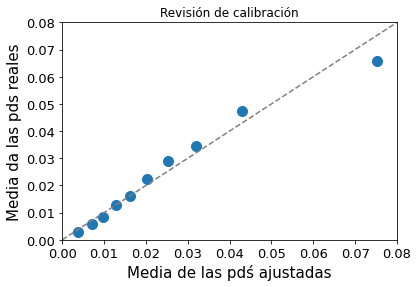

In [62]:
grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time, continuous=False)

El ajuste de las medias reales contra las medias ajustadas no presenta desviaciones considerables

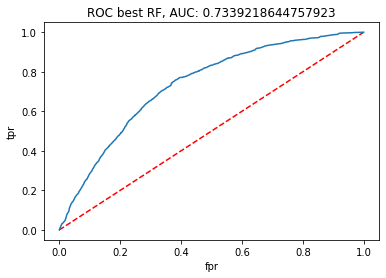

In [63]:
fpr, tpr, thresholds = roc_curve(data_score_regresion['default_time'], pronostico, pos_label=1)
    
plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(data_score_regresion['default_time'], pronostico)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()    

Una manera de evaluar la discriminación dada por el modelo se realiza mediante la [Curva Roc](http://www.navan.name/roc/).
Una curva alejada a la línea punteada representa un modelo de discriminación adecuado. 

Como comparación al modelo obtenido se utilizará el modelo modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html)

In [64]:
model_score = smf.glm('default_time ~ FICO_orig_time_WOE + LTV_orig_time_WOE + \
                      Interest_Rate_orig_time_WOE + hpi_orig_time_WOE', 
                      family = sm.families.Binomial(), data = data_score_regresion).fit()

A continuación se analizarán los coeficientes y *p-value* de cada feature obtenidos del modelo.

In [65]:
print(model_score.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                 4979
Model:                            GLM   Df Residuals:                     4974
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.2
Date:                Wed, 09 Dec 2020   Deviance:                       5380.5
Time:                        09:34:47   Pearson chi2:                 4.90e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Verificaremos que los coeficientes enttr ambos son similares, calcularemos la aproximación de ambos vectores con approx de pytest.

In [66]:
print(model == approx(np.array(model_score.params), abs=1e-1, rel=1e-1))

True


### Resultados

* Los parámetros tienen un coeficiente positivo, por los que incrementos en cada una de ellos tendrán un efecto (no directamente proporcional) positivo en la estimación de la probabilidad para determinar si un préstamo será catalogado como default o no.
* Este tipo de análisis busca proporcionar probabilidades de incumplimiento por individuo, para lo cual se aplican la funcion logística a cada crédito con los valores de sus caracteríticas y sus correspondientes coeficientes. Posteriormente mediante una transformación se asignan puntos o puntos de corte para obtener un score.

# d. Conclusiones

* Las aproximaciones a los parámetros de los modelos de regresión logística son muy similares entre los métodos utilizados del curso y con los obtenidos con `glm`.
* Se complementó el análisis del modelo con la función de la librería `glm` con los *valores p* y se mostró que el uso de las transformaciones utilizadas en la metodología *WOE* e *IV* que ayudan a seleccionar variables cuyo poder explicativo (en relación a la variable dependiente `default_time`) incrementa considerablemente.
* En relación a la sección de Análisis de Componentes Principales, para fines prácticos y académicos únicamente se utilizaron las primeras 2 componentes principales, las cuales fueron obtenidas de manera simple y sus aproximaciones fueron altas. Dado que los $2$ eigenvalores de máximo módulo no se encuentran muy cercanos entre ellos la convergencia del método es alta (no fue necesario de muchas implementaciones del algoritmo). 
* Una mejora a este proyecto se encuentra en la sección de las Componentes Principales, en donde se pudo haber planteado un problema de optimización (no convexo) utilizando las condiciones de Karosh-Kuhn-Tucker ([KKT](https://es.wikipedia.org/wiki/Condiciones_de_Karush-Kuhn-Tucker)) y así poder calcular todas las Componentes Principales.
* La estimación de las probabilidades de incumplimiento no es una tarea sencilla y a pesar de que en este proyecto se presentaron $2$ maneras de realizar dicha estimación en la práctica los modelos predictivos deben y son más robustos que los obtenidos en este proyecto.

# e. Software y referencias
* El lenguaje de programación utilizado en este proyecto es `Python` 

* De manera adicional, se levantó una [instancia **EC2**](http://ec2-3-83-103-223.compute-1.amazonaws.com:8888/lab) en AWS, la cual nos apoyó a trabajar de manera "continua" sobre una serie de algoritmos.

* *Rosch Daniel*, Scheule Harald. Deep Credit Risk. 2020. Amazon Fulfillment, Polonia.

* *Siddiqi, Naeem*. Credit Risk Scorecards, Developing and Implementing Credit Scoring. 2006. Wiley, New Jersey 